In [1]:
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]'

In [2]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import fnmatch
%matplotlib inline 

In [3]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [4]:
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

In [5]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


In [6]:
chm_file = '../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/NEON_D17_SJER_DP3_258000_4108000_CHM.tif'

In [7]:
#Get info from chm file for outputting results
just_chm_file = os.path.basename(chm_file)
just_chm_file_split = just_chm_file.split(sep="_")


In [8]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==int(metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
        return array, metadata

    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

In [9]:
just_chm_file


'NEON_D17_SJER_DP3_258000_4108000_CHM.tif'

In [10]:
just_chm_file_split

['NEON', 'D17', 'SJER', 'DP3', '258000', '4108000', 'CHM.tif']

In [11]:
#Open the CHM file with GDAL
chm_dataset = gdal.Open(chm_file)

#Get the raster band object
chm_raster = chm_dataset.GetRasterBand(1)


In [12]:
#Get the NO DATA value
noDataVal_chm = chm_raster.GetNoDataValue()

In [13]:
#Get required metadata from CHM file
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm =chm_dataset.GetGeoTransform()
xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]
xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]
image_extent = (xMin,xMax,yMin,yMax)

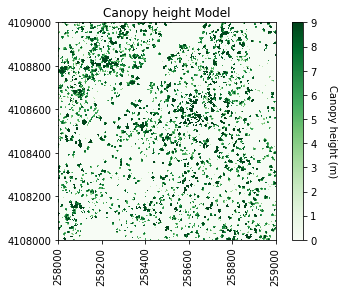

In [14]:
#Plot the original CHM
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)

#PLot the CHM figure
plot_band_array(chm_array,image_extent,'Canopy height Model','Canopy height (m)','Greens',[0, 9])
plt.savefig(just_chm_file_split[0]+'_'+just_chm_file_split[1]+'_'+just_chm_file_split[2]+'_'+just_chm_file_split[3]+'_'+just_chm_file_split[4]+'_'+just_chm_file_split[5]+'_'+'CHM.png',dpi=300,orientation='landscape',bbox_inches='tight',pad_inches=0.1)


In [15]:
#Smooth the CHM using a gaussian filter to remove spurious points
chm_array_smooth = ndi.gaussian_filter(chm_array,2,mode='constant',cval=0,truncate=2.0)
chm_array_smooth[chm_array==0] = 0 

In [16]:
 #Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth,indices=False, footprint=np.ones((5, 5)))

In [17]:
#Identify all the maximum points
markers = ndi.label(local_maxi)[0]

In [18]:
#Create a CHM mask so the segmentation will only occur on the trees
chm2017_mask = chm_array_smooth
chm2017_mask[chm_array_smooth != 0] = 1 

In [19]:
#Perfrom watershed segmentation        
labels = watershed(chm_array_smooth, markers, mask=chm2017_mask)

In [20]:
import os, fnmatch
listOfFiles_2017 = os.listdir('../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
listOfFiles_2018 = os.listdir('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
pattern = "*.tif"  
listOfFiles_2017
print ('')
listOfFiles_2018

['NEON_D17_SJER_DP3_258000_4108000_ARVI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_ARVI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_ARVI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_EVI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_EVI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_EVI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_LAI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDLI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDLI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_NDLI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDNI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDNI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_NDNI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDVI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_NDVI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_NDVI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_PRI.tif',
 'NEON_D17_SJER_DP3_258000_4108000_PRI.tif.aux.xml',
 'NEON_D17_SJER_DP3_258000_4108000_PRI_error.tif',
 'NEON_D17_SJER_DP3_258000_4108000_reflectance.h5

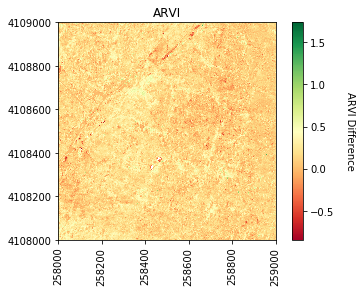

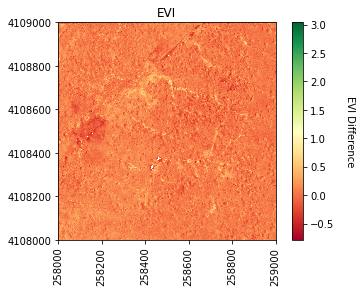

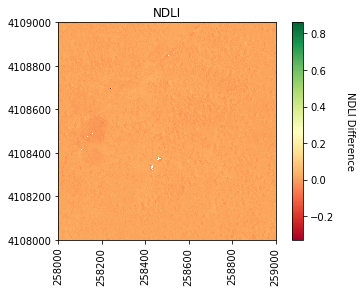

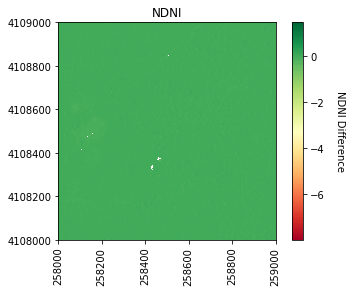

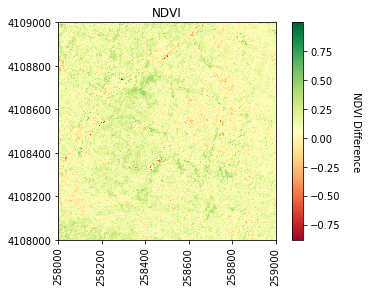

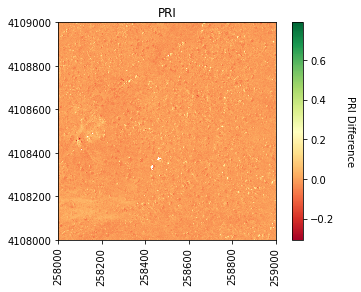

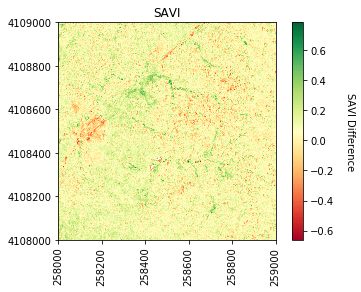

In [27]:
import os, fnmatch
listOfFiles_2017 = os.listdir('../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
listOfFiles_2018 = os.listdir('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
pattern = "*.tif"  

n = 2
for entry_2017 in listOfFiles_2017:
    if fnmatch.fnmatch(entry_2017, pattern):
        for entry_2018 in listOfFiles_2018:
            if fnmatch.fnmatch(entry_2017,entry_2018):
                # read in the corresponding 2017 and 2018 indices
                
                
                index_2017, index_2017_md = raster2array('../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/'+entry_2017)
                index_2018, index_2018_md = raster2array('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_VegIndices/'+entry_2018)
                
                diff_output = index_2017-index_2018
                diff_min = np.nanmin(diff_output)
                diff_max = np.nanmax(diff_output)
                n = n +1
                plt.figure(n)
                plot_band_array(diff_output,
                image_extent, entry_2017[33:-4] , entry_2017[33:-4] + ' Difference','RdYlGn',[diff_min, diff_max])
            

In [24]:
import os, fnmatch
listOfFiles_2017 = os.listdir('../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
listOfFiles_2018 = os.listdir('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_VegIndices/')  
pattern = "*.tif"  

for entry_2017 in listOfFiles_2017:
    if fnmatch.fnmatch(entry_2017, pattern):
        for entry_2018 in listOfFiles_2018:
            if fnmatch.fnmatch(entry_2017,entry_2018):
             
                # read in the corresponding 2017 and 2018 indices
                index_2017, index_2017_md = raster2array('../../Data/capstone/2017/NEON_D17_SJER_DP3_258000_4108000_VegIndices/'+entry_2017)
                index_2018, index_2018_md = raster2array('../../Data/capstone/2018/NEON_D17_SJER_DP3_258000_4108000_VegIndices/'+entry_2018)
                
                diff_output = index_2017-index_2018 
                print('minimum value: ' + str(entry_2017[33:-4]), np.nanmin(diff_output))
                print('maximum value: ' + str(entry_2017[33:-4]), np.nanmax(diff_output))
                print('standard deviation: ' + str(entry_2017[33:-4]), np.nanstd(diff_output))
                print('mean: ' + str(entry_2017[33:-4]), np.nanmean(diff_output))
                print('')
                

minimum value: ARVI -0.8445398807525635
maximum value: ARVI 1.7330170571804047
standard deviation: ARVI 0.13180283217700356
mean: ARVI 0.15931771691521515

minimum value: EVI -0.7860555499792099
maximum value: EVI 3.036120682954788
standard deviation: EVI 0.13142493939351724
mean: EVI 0.08057995603985256

minimum value: NDLI -0.3288665870204568
maximum value: NDLI 0.8600281104445457
standard deviation: NDLI 0.009935404502295598
mean: NDLI 0.012166282612102605

minimum value: NDNI -7.992792121134698
maximum value: NDNI 1.4715066999197006
standard deviation: NDNI 0.026098773013719875
mean: NDNI 0.011894999973323817

minimum value: NDVI -0.8822384476661682
maximum value: NDVI 0.9974058866500854
standard deviation: NDVI 0.10353645582007003
mean: NDVI 0.12058320679022913

minimum value: PRI -0.30694760009646416
maximum value: PRI 0.78909613750875
standard deviation: PRI 0.022088948910160357
mean: PRI -0.0042863920936280185

minimum value: SAVI -0.6614433750510216
maximum value: SAVI 0.78220